# Техзадание на позицию младший аналитик данных
<br>

<br><br>
**Описание работы:**
&nbsp;&nbsp;&nbsp;&nbsp;
<br><br>
&nbsp;&nbsp;&nbsp;&nbsp; Предоставлен набор данных, в которых содержится информация о поступлении денежных средств от
клиентов компании N за покупку ее услуг.

 <br>

&nbsp;&nbsp;&nbsp;&nbsp; **Вопросы:**
1) Вычислите общую выручку за июль 2021 по тем сделкам, приход денежных
средств которых не просрочен.
2) Как изменялась выручка компании за рассматриваемый период?
Проиллюстрируйте графиком.
3) Кто из менеджеров привлек для компании больше всего денежных средств в
сентябре 2021?
4) Какой тип сделок (новая/текущая) был преобладающим в октябре 2021?
5) Сколько оригиналов договора по майским сделкам было получено в июне 2021?


&nbsp;&nbsp;&nbsp;&nbsp; **Задание:**
За каждую заключенную сделку менеджер получает бонус, который рассчитывается
следующим образом.
1) За новые сделки менеджер получает 7 % от суммы, при условии, что статус
оплаты «ОПЛАЧЕНО», а также имеется оригинал подписанного договора с
клиентом (в рассматриваемом месяце).
2) За текущие сделки менеджер получает 5 % от суммы, если она больше 10 тыс.,
и 3 % от суммы, если меньше. При этом статус оплаты может быть любым,
кроме «ПРОСРОЧЕНО», а также необходимо наличие оригинала подписанного
договора с клиентом (в рассматриваемом месяце).
Бонусы по сделкам, оригиналы для которых приходят позже рассматриваемого
месяца, считаются остатком на следующий период, который выплачивается по мере
прихода оригиналов. Вычислите остаток каждого из менеджеров на 01.07.2021
<br><br>
_________

[Codebook](#Codebook) <br>
[1. Описание данных](#1.-Описание-данных)<br>
[2. Исследование зависимостей и формулирование гипотез](#2.-Исследование-зависимостей-и-формулирование-гипотез)<br>
[3. Построение моделей для прогнозирования оттока](#3.-Построение-модели-для-кластеризации)<br>
[4. Сравнение качества моделей](#4.-Описание-полученных-кластеров) <br>

## Codebook
<br>

[Ссылка для скачивания данных](https://docs.google.com/spreadsheets/d/1t2Bl9Jc0JCWOaeFgADJ2bVdoLdjDTWno/edit?usp=drive_link) 
<br><br>

`data.xlsx` содержит следующие значения:<br><br>

&nbsp;&nbsp;&nbsp;&nbsp; `client_id` - ID клиента<br>
&nbsp;&nbsp;&nbsp;&nbsp; `sum` – сумма денежных средств<br>
&nbsp;&nbsp;&nbsp;&nbsp; `status` – статус оплаты<br>
&nbsp;&nbsp;&nbsp;&nbsp; `sale` – менеджер, заключивший сделку<br>
&nbsp;&nbsp;&nbsp;&nbsp; `new/current` – статус сделки<br>
&nbsp;&nbsp;&nbsp;&nbsp; `document` – наличие оригинала подписанного договора с клиентом<br>
&nbsp;&nbsp;&nbsp;&nbsp; `receiving_date` – дата получения оригинала договора<br>

In [110]:
# Загрузка библиотек и модулей
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt 


from yellowbrick.cluster import KElbowVisualizer
import warnings
#warnings.filterwarnings("ignore")
# , category=FutureWarning
%matplotlib inline

# 1. Описание данных

In [262]:
### Загрузка данных ###
source_df = pd.read_excel("data.xlsx")

# Для EDA делаем копию датафрейма и с ней будем работать.
eda_df = source_df.copy()

# Убираем столбцы Unnamed: 5.
eda_df = eda_df.drop(['Unnamed: 5'], axis=1, errors='ignore')

# Посмотрим на датасет и на типы данных по столбцам
eda_df.info()
eda_df.tail()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   client_id       724 non-null    float64
 1   sum             724 non-null    float64
 2   status          730 non-null    object 
 3   sale            724 non-null    object 
 4   new/current     724 non-null    object 
 5   document        709 non-null    object 
 6   receiving_date  607 non-null    object 
dtypes: float64(2), object(5)
memory usage: 40.1+ KB


,client_id,sum,status,sale,new/current,document,receiving_date
725,285.0,4328.7,ОПЛАЧЕНО,Васильев,текущая,оригинал,2021-11-15 00:00:00
726,360.0,3096.2,ОПЛАЧЕНО,Васильев,новая,НЕТ,NaN
727,360.0,3096.2,ПРОСРОЧЕНО,Васильев,новая,НЕТ,NaN
728,373.0,4403.7,ОПЛАЧЕНО,Михайлов,новая,оригинал,2021-11-08 00:00:00
729,286.0,3978.7,ОПЛАЧЕНО,Филимонова,текущая,оригинал,2021-11-15 00:00:00


In [263]:
# Выведем на экран строки с NaN значениями
eda_df[eda_df['client_id'].isnull()]

,client_id,sum,status,sale,new/current,document,receiving_date
0,NaN,NaN,Май 2021,NaN,NaN,NaN,NaN
129,NaN,NaN,Июнь 2021,NaN,NaN,NaN,NaN
258,NaN,NaN,Июль 2021,NaN,NaN,NaN,NaN
369,NaN,NaN,Август 2021,NaN,NaN,NaN,NaN
484,NaN,NaN,Сентябрь 2021,NaN,NaN,NaN,NaN
594,NaN,NaN,Октябрь 2021,NaN,NaN,NaN,NaN


In [264]:
# Удалим эти 6 строк, в которых нет данных
eda_df = eda_df.dropna(subset=['client_id'])

In [265]:
# Проанализируем строки, в которых есть отсутствующие данные в столбце "document"
eda_df[eda_df['document'].isnull()]

,client_id,sum,status,sale,new/current,document,receiving_date
47,87.0,9948.7,ОПЛАЧЕНО,Смирнов,новая,NaN,2021-06-17 00:00:00
48,90.0,16123.7,ОПЛАЧЕНО,Смирнов,текущая,NaN,2021-07-28 00:00:00
49,91.0,1053.7,ОПЛАЧЕНО,Смирнов,текущая,NaN,2021-07-28 00:00:00
93,198.0,4458.7,ОПЛАЧЕНО,Смирнов,текущая,NaN,2021-07-01 00:00:00
189,115.0,298.7,ОПЛАЧЕНО,Андреев,текущая,NaN,2021-07-14 00:00:00
337,228.0,2193.7,ОПЛАЧЕНО,Смирнов,текущая,NaN,2021-10-06 00:00:00
376,32.0,7101.7,ОПЛАЧЕНО,Филимонова,текущая,NaN,2021-10-06 00:00:00
409,90.0,8454.2,ОПЛАЧЕНО,Смирнов,текущая,NaN,2021-09-20 00:00:00
453,339.0,7553.7,ОПЛАЧЕНО,Петрова,новая,NaN,2021-10-11 00:00:00
459,256.0,2351.2,ОПЛАЧЕНО,Филимонова,текущая,NaN,NaN


Эти строки имеют наполнение, их оставляем

In [266]:
# Получим описание всех столбцов
eda_df.describe(include = "all")

,client_id,sum,status,sale,new/current,document,receiving_date
count,724.000000,724.000000,724,724,724,709,607
unique,NaN,NaN,5,12,3,3,111
top,NaN,NaN,ОПЛАЧЕНО,Петрова,текущая,оригинал,2021-08-10 00:00:00
freq,NaN,NaN,622,169,620,595,19
mean,183.084254,7162.542030,NaN,NaN,NaN,NaN,NaN
std,106.590761,6308.571297,NaN,NaN,NaN,NaN,NaN
min,6.000000,23.700000,NaN,NaN,NaN,NaN,NaN
25%,86.000000,3114.732500,NaN,NaN,NaN,NaN,NaN
50%,194.000000,5207.990000,NaN,NaN,NaN,NaN,NaN
75%,273.000000,8934.950000,NaN,NaN,NaN,NaN,NaN


In [267]:
# Уникальные значения в колонке 'status'
print('Уникальные значения в колонке "status": ',eda_df['status'].unique())

Уникальные значения в колонке "status":  ['ВНУТРЕННИЙ' 'ОПЛАЧЕНО' 'ПРОСРОЧЕНО' 'В РАБОТЕ' 'НА ПОДПИСАНИИ']


In [268]:
# Рассмотрим строки со значением статуса "ВНУТРЕННИЙ"
eda_df[eda_df['status'] == 'ВНУТРЕННИЙ']

,client_id,sum,status,sale,new/current,document,receiving_date
1,6.0,11693.7,ВНУТРЕННИЙ,-,-,-,-


Удалим эту строку для дальнейших исследований

In [269]:
eda_df = eda_df[eda_df['status'] != 'ВНУТРЕННИЙ']

## 2. Исследование зависимостей

1) Вычислите общую выручку за июль 2021 по тем сделкам, приход денежных
средств которых не просрочен.
2) Как изменялась выручка компании за рассматриваемый период?
Проиллюстрируйте графиком.
3) Кто из менеджеров привлек для компании больше всего денежных средств в
сентябре 2021?
4) Какой тип сделок (новая/текущая) был преобладающим в октябре 2021?
5) Сколько оригиналов договора по майским сделкам было получено в июне 2021?

In [270]:
# Преобразуем столбец 'receiving_date' во временной формат
eda_df['receiving_date'] = eda_df['receiving_date'].astype("datetime64[ns]")

In [271]:
# Вычислим общую выручку за июль 2021 по тем сделкам, приход денежных средств которых не просрочен.
july_2021 = eda_df[(eda_df['receiving_date'].dt.to_period("M") == '2021-07') & (eda_df['status'] != 'ПРОСРОЧЕНО')]
print('Общая выручка за июль 2021 по тем сделкам, приход денежных средств которых не просрочен: ', 
      round(july_2021['sum'].sum(), 2))

Общая выручка за июль 2021 по тем сделкам, приход денежных средств которых не просрочен:  757830.74


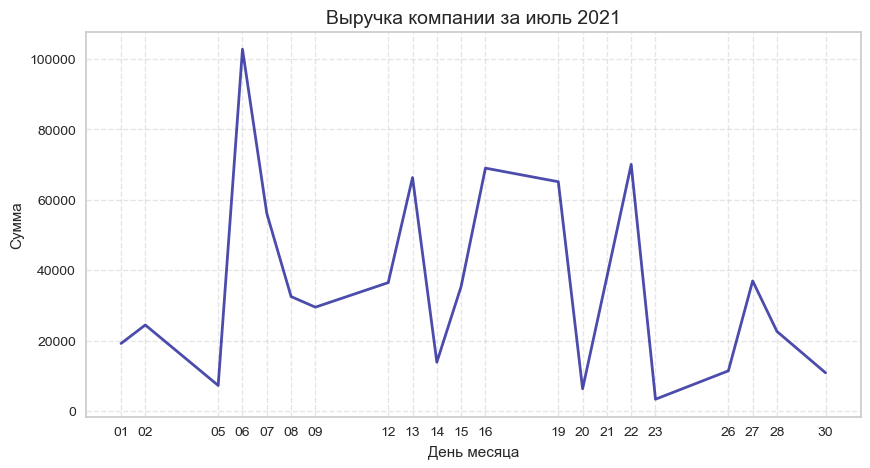

In [272]:
# Рассмотрим как изменялась выручка компании за рассматриваемый период. Построим график.
df = july_2021.groupby('receiving_date', as_index = False).agg({'sum': 'sum'})

fig, ax = plt.subplots(figsize=(10,5))
ax.plot(df['receiving_date'], df['sum'], color='darkblue', lw=2, alpha=0.7)
ax.set_title('Выручка компании за июль 2021', fontsize=14)
ax.set_xticks(df['receiving_date'])
ax.set_xticklabels(sorted(df['receiving_date'].dt.strftime('%d')))
ax.set_xlabel('День месяца')
ax.set_ylabel('Сумма')
ax.grid(alpha=0.5, ls='--')

plt.show()

C:\Users\persi\AppData\Local\Temp\ipykernel_2468\2654593428.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  july_2021['day'] = july_2021['receiving_date'].dt.strftime('%w')


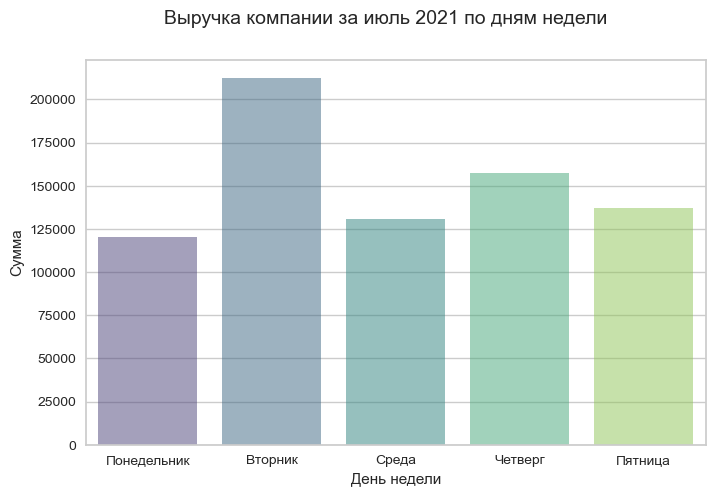

In [273]:
# Рассмотрим как изменялась выручка компании за рассматриваемый период в разрезе дней недели. Построим график.
july_2021['day'] = july_2021['receiving_date'].dt.strftime('%w')
df = july_2021.groupby('day', as_index = False).agg({'sum': 'sum'})

fig, ax = plt.subplots(figsize = (8, 5))
sns.barplot(data = df, x = 'day', y = 'sum', ax = ax, alpha = 0.5, errorbar=None, palette = 'viridis')
ax.set_ylabel('Сумма')
ax.set_xlabel('День недели')
ax.set(xticklabels=['Понедельник','Вторник', 'Среда', 'Четверг', 'Пятница'])
fig.suptitle('Выручка компании за июль 2021 по дням недели', fontsize=14)
plt.show()

Вторник выделяется своей активностью.

In [274]:
# Топ-3 менеджеров, кто привлек для компании больше всего денежных средств в сентябре 2021

eda_df[eda_df['receiving_date'].dt.to_period("M") == '2021-09'].groupby('sale', as_index = False).agg(
    {'sum': 'sum'}).sort_values('sum', ascending = False).head(3)

,sale,sum
4,Петрова,219240.12
2,Иванов,165314.80
5,Смирнов,155245.90


In [275]:
# Какой тип сделок (новая/текущая) был преобладающим в октябре 2021?

eda_df[eda_df['receiving_date'].dt.to_period("M") == '2021-10'].value_counts('new/current')

new/current
текущая    105
новая       17
Name: count, dtype: int64

In [276]:
print('В октябре преобладал тип сделок {} : {}'.format(
    max(eda_df[eda_df['receiving_date'].dt.to_period("M") == '2021-10'].value_counts('new/current').index),
    max(eda_df[eda_df['receiving_date'].dt.to_period("M") == '2021-10'].value_counts('new/current'))))

В октябре преобладал тип сделок текущая : 105


In [277]:
# Сколько оригиналов договора по майским сделкам было получено в июне 2021?
print('В июне 2021 по майским сделкам было получено {} оригиналов договора'.format(
    eda_df[(eda_df['receiving_date'].dt.to_period("M") == '2021-06') & (eda_df['new/current'] == 'текущая')].shape[0]))

В июне 2021 по майским сделкам было получено 72 оригиналов договора


## 2. Расчет бонусов

 Задание: За каждую заключенную сделку менеджер получает бонус, который рассчитывается следующим образом.

1. За новые сделки менеджер получает 7 % от суммы, при условии, что статус оплаты «ОПЛАЧЕНО», а также имеется оригинал подписанного договора с клиентом (в рассматриваемом месяце).

2. За текущие сделки менеджер получает 5 % от суммы, если она больше 10 тыс., и 3 % от суммы, если меньше. При этом статус оплаты может быть любым, кроме «ПРОСРОЧЕНО», а также необходимо наличие оригинала подписанного договора с клиентом (в рассматриваемом месяце). Бонусы по сделкам, оригиналы для которых приходят позже рассматриваемого месяца, считаются остатком на следующий период, который выплачивается по мере прихода оригиналов. Вычислите остаток каждого из менеджеров на 01.07.2021


In [278]:
eda_df

,client_id,sum,status,sale,new/current,document,receiving_date
2,14.0,5452.7,ОПЛАЧЕНО,Петрова,новая,оригинал,2021-07-26
3,15.0,13991.7,ОПЛАЧЕНО,Иванов,текущая,оригинал,2021-06-08
4,16.0,719.7,ОПЛАЧЕНО,Иванов,текущая,оригинал,2021-06-08
5,18.0,4253.7,ОПЛАЧЕНО,Иванов,текущая,оригинал,2021-07-07
6,20.0,5796.7,ОПЛАЧЕНО,Кузнецова,текущая,оригинал,2021-07-15
...,...,...,...,...,...,...,...
725,285.0,4328.7,ОПЛАЧЕНО,Васильев,текущая,оригинал,2021-11-15
726,360.0,3096.2,ОПЛАЧЕНО,Васильев,новая,НЕТ,NaT
727,360.0,3096.2,ПРОСРОЧЕНО,Васильев,новая,НЕТ,NaT
728,373.0,4403.7,ОПЛАЧЕНО,Михайлов,новая,оригинал,2021-11-08


In [283]:
# За новые сделки менеджер получает 7 % от суммы, при условии, что статус оплаты «ОПЛАЧЕНО», 
#а также имеется оригинал подписанного договора с клиентом (в рассматриваемом месяце).
eda_df['bonus'] = eda_df[(eda_df['new/current'] == 'новая') & 
    (eda_df['status'] == 'ОПЛАЧЕНО') & 
    (eda_df['document'] == 'оригинал')]['sum'] * 0.07

In [286]:
#За текущие сделки менеджер получает 5 % от суммы, если она больше 10 тыс., и 3 % от суммы, если меньше. 
#При этом статус оплаты может быть любым, кроме «ПРОСРОЧЕНО», а также необходимо наличие оригинала подписанного 
#договора с клиентом (в рассматриваемом месяце).
eda_df['bonus'] = eda_df[(eda_df['new/current'] == 'текущая') & 
    (eda_df['status'] != 'ПРОСРОЧЕНО') & 
    (eda_df['document'] == 'оригинал')]['sum'].apply(lambda x: 0.05 * x if x > 10000 else 0.03 * x)

In [291]:
#Бонусы по сделкам, оригиналы для которых приходят позже рассматриваемого месяца, считаются остатком на следующий период, 
#который выплачивается по мере прихода оригиналов. Вычислите остаток каждого из менеджеров на 01.07.2021

eda_df[(eda_df['receiving_date'].dt.to_period("M") == '2021-07') & 
       (eda_df['new/current'] == 'текущая')].groupby('sale').agg({'bonus': 'sum'})

,bonus
sale,
Андреев,3681.0017
Васильев,479.8560
Иванов,4080.4640
Кузнецова,3258.9336
Петрова,5126.1894
Селиванов,960.7770
Смирнов,5470.9100
Филимонова,836.2545
